## Mushroom Image Classification ##

Welcome! In this project it is our goal to download different images of mushrooms, coded by their genus, and train a machine learning model to properly recognize the genus based purely on the image.  

This dataset comes from Kaggle.com. There are a few different mushroom datasets within the Kaggle universe, but the one we're using here is: https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images. 

As usual, we will start by loading several useful libraries into our environment, and seeing where we are in the system:

In [4]:
# Load relevant libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import seaborn as sns
import time
%matplotlib inline
plt.style.use('seaborn-whitegrid')

os.getcwd()

'C:\\Users\\David Olivero\\AnacondaProjects\\Mushrooms'

The data, about 1 GB in mushroom images in all, were downloaded as a zip file to the local system, then unpacked. We can see that the different mushroom types are located in subfolders:

In [5]:
print(os.listdir("../Mushrooms/Types"))

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


We'll continue with loading some libraries to help look at images:

In [6]:
from PIL import Image
import glob

In [7]:
from skimage import color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread
import PIL

In [8]:
# Define a function to help look at images. This function turns off the axes and includes color map and title. 

def show_image(image, title='Image', cmap_type='gray'): 
    plt.imshow(image, cmap=cmap_type)        
    plt.title(title)    
    plt.axis('off')    
    plt.show()


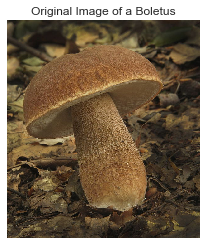

In [13]:
# Let's get an image of a Boletus mushroom and plot it

img_file = 'Boletus/0144_9a0yRDYfJsk.jpg'
data = plt.imread(img_file)
show_image(data, "Original Image of a Boletus")


That's a pretty square image, but not all of them look like that. Take this one for example:

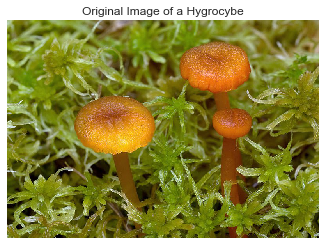

In [14]:
img_file = 'Hygrocybe/319_rWty9nU7yew.jpg'
data = plt.imread(img_file)
show_image(data, "Original Image of a Hygrocybe")

In [15]:
data.shape

(559, 800, 3)

This image is 559 X 800, which is pretty typical for this dataset. In all likelihood we'll want to reduce the pixel count for faster modeling, not to mention consistency across images. What happens to this image when we resize it? The axis with the higher pixel count will get squashed, as can be seen below. 

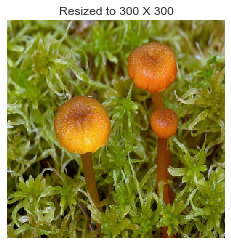

In [23]:
im = resize(data, (300,300,3),anti_aliasing=True)
plt.imshow(im)
plt.title('Resized to 300 X 300')
plt.axis('off')
plt.show()


It can be seen that the images come in a variety of sizes and aspect ratios. We need a comprehensive approach to dealing with this. One possible approach is to crop the images into perfect squares. This can work if the mushroom image is sufficiently centered in the full image, and is small enough not to get clipped off by the cropping. Here we define a function that takes an aribitrary aspect ratio image and returns a perfectly square one of maximum size:

In [24]:
def crop(im):
    ax0 = im.shape[0]
    ax1 = im.shape[1]
    if ax1 > ax0:
        lower = int(ax1/2 - ax0/2)
        upper = int(ax1/2 + ax0/2)
        im = im[:,lower:upper,:]
    else:
        lower = int(ax0/2 - ax1/2)
        upper = int(ax0/2 + ax1/2)
        im = im[lower:upper,:,:]
        
    return im

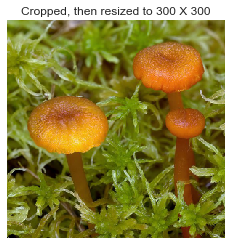

In [26]:
#Take the hygrocybe image, crop it, then replot it:

data1 = crop(data)

im = resize(data1, (300,300,3),anti_aliasing=True)
plt.imshow(im)
plt.title('Cropped, then resized to 300 X 300')
plt.axis('off')
plt.show()

In some cases, like above, this cropping may result in a good compromise between quality and image size.   

In other cases, we may not be so lucky, as can be seen below:

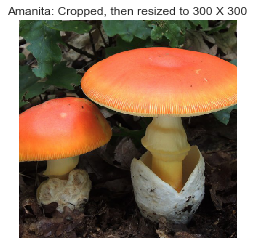

In [27]:
# Process an image of an Amanita mushroom:

img_file = 'Amanita/013_6tvG-1vnN90.jpg'
data = plt.imread(img_file)
data1 = crop(data)
im = resize(data1, (300,300,3),anti_aliasing=True)
plt.imshow(im)
plt.title('Amanita: Cropped, then resized to 300 X 300')
plt.axis('off')
plt.show()

## Other transformations: Grayscale and beyond ##
To gain more insight into our dataset, try some other techniques on the images:

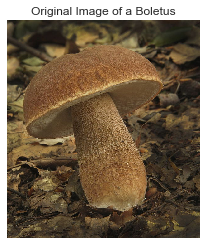

In [28]:
# Let's return to the first image of the Boletus mushroom and plot it:

img_file = 'Boletus/0144_9a0yRDYfJsk.jpg'
data = plt.imread(img_file)
show_image(data, "Original Image of a Boletus")

For a given pixel location (as shown below, we get a three element array, which comprises the Red, Blue and Green channels of the image. The values are integers within the range (0, 255). 

In [30]:
data[100,100,:]

array([76, 67, 52], dtype=uint8)

In [31]:
# Import the rgb2gray method:

from skimage import color
grayscale = color.rgb2gray(data)



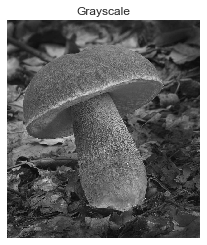

In [32]:
# Replot the image as grayscale:

show_image(grayscale, 'Grayscale')

In [35]:
print('Color size is:', data.size, ' and grayscale size for same image is:', grayscale.size)

Color size is: 1300140  and grayscale size for same image is: 433380


One benefit of converting an image to grayscale is the compression of data from three color channels to one grayscale channel. We can also try some other techniques. For example, edge detect filtering: 

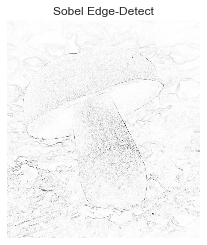

In [34]:
# Let's try applying an edge-detect filter
from skimage.filters import sobel
edge_sobel = sobel(grayscale)
plt.imshow(edge_sobel)
plt.title('Sobel Edge-Detect')
plt.axis('off')
plt.show()

There's also a technique called thresholding that might be useful. In thresholding a grayscale image, we assign a threshold value for a pixel, and if the grayscale value is greater than our threshold, we go full white, i.e., a value of 1. Less than the threshold goes to full black, i.e., a value of 0. There's two ways to threshold; globally and locally. 

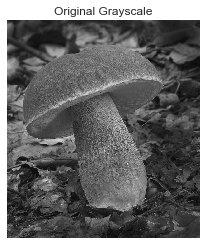

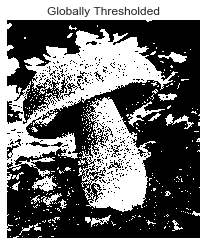

In [40]:
# Let's try some thresholding on the grayscale image. We'll start with global thresholding
# Obtain the optimal threshold value
thresh = .35

# Apply thresholding to the image
binary = grayscale > thresh
# Show the original and thresholded
show_image(grayscale, 'Original Grayscale')
show_image(binary, 'Globally Thresholded')


In [41]:
# Also trying local thresholding to see how that compares.
from skimage.filters import threshold_local
# Set the block size to 35
block_size = 35
# Obtain the optimal local thresholding
local_thresh = threshold_local(grayscale, block_size, offset=.02)
# Apply local thresholding and obtain the binary image
binary_local = grayscale > local_thresh


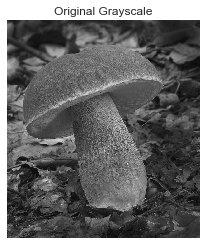

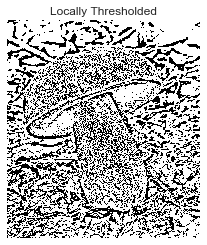

In [42]:
show_image(grayscale, 'Original Grayscale')
show_image(binary_local, 'Locally Thresholded')

Lastly, we can explore a technique called segmentation, which seeks to create kind of a "paint by numbers" version of our original color image:

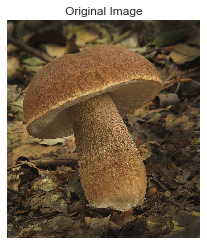

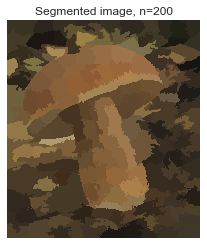

In [45]:
# Import the modules
from skimage.segmentation import slic
from skimage.color import label2rgb
# Obtain the segments
segments = slic(data, n_segments = 200)
# Put segments on top of original image to compare
segmented_image = label2rgb(segments, data, kind='avg')
show_image(data, 'Original Image')
show_image(segmented_image, "Segmented image, n=200")


So far, we've looked at images from a data perspective: size, color vs. grayscale, and different kinds of filtering. But there are other factors that we will need to address in our next steps.  

First, the presence of clearly poor images. Like these:

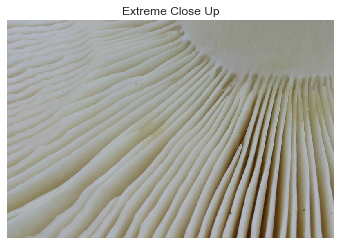

In [47]:
img_file = 'Rejected/Russula/595_HtNV0jL8OVs.jpg'
data = plt.imread(img_file)
show_image(data, "Extreme Close Up")


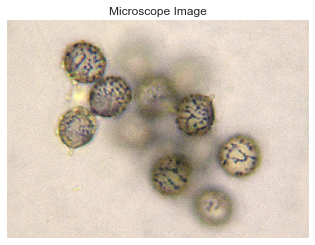

In [48]:
img_file = 'Rejected/Russula/043_a_5lm55zCVc.jpg'
data = plt.imread(img_file)
show_image(data, "Microscope Image")

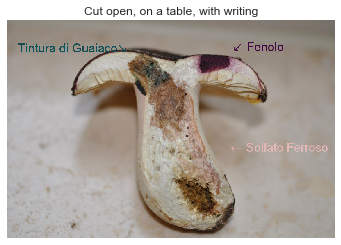

In [49]:
img_file = 'Rejected/Russula/570_fAMw1tbA94k.jpg'
data = plt.imread(img_file)
show_image(data, "Cut open, on a table, with writing")

These images, and others like them, will have to be removed from the image set, so we can focus on images of whole mushrooms, in their natural setting.  

Even then, we can still get into some trouble perhaps, as over zealous mushroom hunters cram so many mushrooms into a single photo, one pities the poor computer program trying to train!

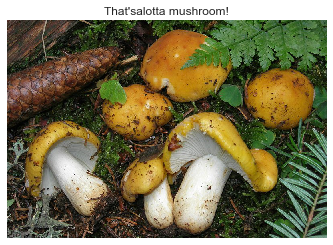

In [50]:
img_file = 'Russula/576_0Cun29U4I2g.jpg'
data = plt.imread(img_file)
show_image(data, "That'salotta mushroom!")

The solution to this, prior to preprocessing in the next notebook, will be to cull poor images from the dataset manually, one by one, and to essentially "curate" a relatively clean image set for preprocessing and modeling. 